In [3]:
import bempp.api
from bempp.api.assembly.blocked_operator import BlockedOperator
import math
import numpy as np
import scipy 
import cmath
from numba import objmode
from numpy.linalg import slogdet
from bempp.api.operators.far_field import helmholtz as helmholtz_farfield
import matplotlib.pyplot as plt
#bempp.core.opencl_kernels.set_default_device(0,0)

In [4]:
h = 0.1
sphere1 = bempp.api.shapes.sphere(r = 1, h=h, origin=(1.25, 0, 0))
sphere2 = bempp.api.shapes.sphere(r = 1, h=h, origin=(-1.25, 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

In [3]:
wavenumber = 0.8

slp11 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
slp12 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere1, space_sphere1, wavenumber)
slp21 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere2 , space_sphere2 , wavenumber)
slp22 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2 , space_sphere2 , space_sphere2 , wavenumber)

mat11 = slp11.weak_form().A
mat12 = slp12.weak_form().A
mat21 = slp21.weak_form().A
mat22 = slp22.weak_form().A
mat12_zero = np.zeros((mat11.shape[0],mat12.shape[1]))
mat21_zero = np.zeros((mat22.shape[0],mat11.shape[1]))

mat = np.block([[mat11,mat12],[mat21,mat22]])  
mat2 = np.block([[mat11,mat12_zero],[mat21_zero,mat22]])

print(-np.imag(np.log(np.linalg.det(mat @ np.linalg.inv(mat2))))/np.pi)

0.07421310022406735


In [4]:
mat12.shape

(1598, 1594)

In [ ]:
0.0744954

In [5]:
deg = 5

def normalized_spherical_harmonics(p, q, x):
    """Spherical Harmonic function of degree q"""
    azimuth = np.arctan2(x[1],x[0])
    polar = np.arccos(x[2]/np.linalg.norm(x))
    if p >= 0:
        return ((-1)**p) * scipy.special.sph_harm(p,q,azimuth,polar)
    else:
        return scipy.special.sph_harm(-p,q,azimuth,polar)*np.exp(1j*2*p*azimuth)

def spherical_bessel_function(q,x):
    """Spherical Bessel function of degree q"""
    r = np.linalg.norm(x)
    return np.sqrt(np.pi/(2*wavenumber*r))*scipy.special.jv(q+0.5, wavenumber*r)

def regular_spherical_wavefunctions(p,q,x):
    """Regular Spherical Wavefunction"""
    return spherical_bessel_function(q,x)*normalized_spherical_harmonics(p,q,x)

In [6]:
h = 0.2
sphere1 = bempp.api.shapes.sphere(r = 1, h=h, origin=(1.25, 0, 0))
sphere2 = bempp.api.shapes.sphere(r = 1, h=h, origin=(-1.25, 0, 0))

space_sphere1 = bempp.api.function_space(sphere1, "P", 1)
space_sphere2 = bempp.api.function_space(sphere2, "P", 1)

In [7]:
unit_sphere = bempp.api.shapes.sphere(r = 1, origin=(0,0,0), h = h)
vert_unit_sphere = unit_sphere.vertices
space_unit_sphere = bempp.api.function_space(unit_sphere, 'P', 1)

combined_scatters = bempp.api.grid.grid.union([sphere1,sphere2])
space_combined = bempp.api.function_space(combined_scatters,'P',1)

In [ ]:
sph_harm_coeff = []

for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def sph_harm(x,n,domain_index,result):
            with objmode():
                result[0] = normalized_spherical_harmonics(p,q,x)
        sph_harm_grid = bempp.api.GridFunction(space_unit_sphere, fun = sph_harm)
        sph_harm_coeff.append(np.conj(sph_harm_grid.coefficients)/((-1j)**(q+1)))

mass_mat = bempp.api.operators.boundary.sparse.identity(space_unit_sphere, space_unit_sphere, space_unit_sphere).weak_form().A

In [79]:
wavenumber = 0.8
eta = wavenumber

identity1 = bempp.api.operators.boundary.sparse.identity(space_sphere1, space_sphere1, space_sphere1)
slp1 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
dlp1 = bempp.api.operators.boundary.helmholtz.double_layer(space_sphere1, space_sphere1, space_sphere1, wavenumber)
slp_far1 = helmholtz_farfield.single_layer(space_sphere1, vert_unit_sphere, wavenumber)
dlp_far1 = helmholtz_farfield.double_layer(space_sphere1, vert_unit_sphere, wavenumber)

lhs1 = 0.5 * identity1 + dlp1 - 1j* eta *slp1

identity2 = bempp.api.operators.boundary.sparse.identity(space_sphere2, space_sphere2, space_sphere2)
slp2 = bempp.api.operators.boundary.helmholtz.single_layer(space_sphere2, space_sphere2, space_sphere2, wavenumber)
dlp2 = bempp.api.operators.boundary.helmholtz.double_layer(space_sphere2, space_sphere2, space_sphere2, wavenumber)
slp_far2 = helmholtz_farfield.single_layer(space_sphere2, vert_unit_sphere, wavenumber)
dlp_far2 = helmholtz_farfield.double_layer(space_sphere2, vert_unit_sphere, wavenumber)

lhs2 = 0.5 * identity2 + dlp2 - 1j* eta *slp2

identity = bempp.api.operators.boundary.sparse.identity(space_combined, space_combined, space_combined)
slp = bempp.api.operators.boundary.helmholtz.single_layer(space_combined, space_combined, space_combined, wavenumber)
dlp = bempp.api.operators.boundary.helmholtz.double_layer(space_combined, space_combined, space_combined, wavenumber)
slp_far = helmholtz_farfield.single_layer(space_combined, vert_unit_sphere, wavenumber)
dlp_far = helmholtz_farfield.double_layer(space_combined, vert_unit_sphere, wavenumber)

lhs = 0.5 * identity + dlp - 1j* eta *slp

slp_far_field_coeff1 = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)

        rhs_fun1 = bempp.api.GridFunction(space_sphere1, fun = dirichlet_fun)
        field1, info1 = bempp.api.linalg.gmres(lhs1, rhs_fun1, tol=1E-8)
        slp_far_field_coeff1.append(dlp_far1.evaluate(field1) - 1j * eta * slp_far1.evaluate(field1))

slp_far_field_coeff2 = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)
        rhs_fun2 = bempp.api.GridFunction(space_sphere2, fun = dirichlet_fun)
        field2, info2 = bempp.api.linalg.gmres(lhs2, rhs_fun2, tol=1E-8)
        slp_far_field_coeff2.append(dlp_far2.evaluate(field2) - 1j * eta * slp_far2.evaluate(field2))

slp_far_field_coeff = []
for q in range(deg+1):
    for p in range(-q,q+1):
        @bempp.api.complex_callable
        def dirichlet_fun(x,n,domain_index,result):
                with objmode():
                    result[0] = - regular_spherical_wavefunctions(p,q,x)

        rhs_fun = bempp.api.GridFunction(space_combined, fun = dirichlet_fun)
        field, info = bempp.api.linalg.gmres(lhs, rhs_fun, tol=1E-8)
        slp_far_field_coeff.append(dlp_far.evaluate(field) - 1j * eta * slp_far.evaluate(field))

T_matrix1 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix1[i,j] = (slp_far_field_coeff1[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

T_matrix2 = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix2[i,j] = (slp_far_field_coeff2[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

T_matrix = np.zeros(((deg+1)**2,(deg+1)**2),dtype = complex)
for i in range((deg+1)**2):
    for j in range((deg+1)**2):
        T_matrix[i,j] = (slp_far_field_coeff[j] @ mass_mat @ sph_harm_coeff[i])*wavenumber

S_matrix = np.identity(T_matrix.shape[0]) + 2*T_matrix
S_matrix1 = np.identity(T_matrix1.shape[0]) + 2*T_matrix1
S_matrix2 = np.identity(T_matrix2.shape[0]) + 2*T_matrix2

#rhs_value_S =  (np.log(np.linalg.det(S_matrix))-(np.log(np.linalg.det(S_matrix1)) + np.log(np.linalg.det(S_matrix2))))
rhs_value_S =  np.log(np.linalg.det(S_matrix)/(np.linalg.det(S_matrix1)*np.linalg.det(S_matrix2)))

print(rhs_value_S/(2*1j*np.pi))

(0.07244898289407836-0.00014974416829894853j)


In [2]:
mat_h_02_04 = [0.0521646, 0.0270904, 0.00350443]
mat_h_015_04 = [0.0525957, 0.0273818, 0.00362706]
mat_h_01_04 = [0.0528549, 0.0275563, 0.00370040]
mat_h_005_04 = [0.0530376, 0.0276791, 0.00375248]

mat_h_02_08 = [0.0724489, 0.00821344, -0.00737313]
mat_h_015_08 = [0.0733953, 0.00868758 , -0.00738171]
mat_h_01_08 = [0.0739640, 0.00896901, -0.00738616]
mat_h_005_08 = [0.0743643, 0.00916690, -0.00738989]

slp_h_02_04 = [0.0526301, 0.0274089, 0.00366112]
slp_h_015_04 = [0.0528464, 0.0275537, 0.00371188]
slp_h_01_04 = [0.0529762, 0.0276395, 0.00374154]
slp_h_005_04 = [0.0530675, 0.0276997, 0.00376272]

slp_h_02_08 = [0.0734096, 0.00879472, -0.00725106]
slp_h_015_08 = [0.0739113, 0.00900013, -0.00731660]
slp_h_01_08 = [0.0742131, 0.00911984, -0.00735546]
slp_h_005_08 = [0.0744258, 0.00920425, -0.00738269 ]

Alex_04 = [0.0530974, 0.0277196, 0.0037697]
Alex_08 = [0.0744954, 0.00923223, -0.00739161]

In [3]:
h_axis = [0.05, 0.1, 0.15, 0.2]

In [4]:
# relative distance between mat and Alex

# k = 0.4
rel_dist_05_mat_k04 = [abs(mat_h_005_04[0] - Alex_04[0])/Alex_04[0], abs(mat_h_01_04[0] - Alex_04[0])/Alex_04[0], 
                      abs(mat_h_015_04[0] - Alex_04[0])/Alex_04[0], abs(mat_h_02_04[0] - Alex_04[0])/Alex_04[0]]

rel_dist_15_mat_k04 = [abs(mat_h_005_04[1] - Alex_04[1])/Alex_04[1], abs(mat_h_01_04[1] - Alex_04[1])/Alex_04[1], 
                      abs(mat_h_015_04[1] - Alex_04[1])/Alex_04[1], abs(mat_h_02_04[1] - Alex_04[1])/Alex_04[1]]

rel_dist_3_mat_k04 = [abs(mat_h_005_04[2] - Alex_04[2])/Alex_04[2], abs(mat_h_01_04[2] - Alex_04[2])/Alex_04[2], 
                      abs(mat_h_015_04[2] - Alex_04[2])/Alex_04[2], abs(mat_h_02_04[2] - Alex_04[2])/Alex_04[2]]

# k = 0.8 ========================================================================================================
rel_dist_05_mat_k08 = [abs(mat_h_005_08[0] - Alex_08[0])/Alex_08[0], abs(mat_h_01_08[0] - Alex_08[0])/Alex_08[0], 
                      abs(mat_h_015_08[0] - Alex_08[0])/Alex_08[0], abs(mat_h_02_08[0] - Alex_08[0])/Alex_08[0]]

rel_dist_15_mat_k08 = [abs(mat_h_005_08[1] - Alex_08[1])/Alex_08[1], abs(mat_h_01_08[1] - Alex_08[1])/Alex_08[1], 
                      abs(mat_h_015_08[1] - Alex_08[1])/Alex_08[1], abs(mat_h_02_08[1] - Alex_08[1])/Alex_08[1]]

rel_dist_3_mat_k08 = [abs(mat_h_005_08[2] - Alex_08[2])/abs(Alex_08[2]), abs(mat_h_01_08[2] - Alex_08[2])/abs(Alex_08[2]), 
                      abs(mat_h_015_08[2] - Alex_08[2])/abs(Alex_08[2]), abs(mat_h_02_08[2] - Alex_08[2])/abs(Alex_08[2])]

# relative distance between slp and Alex ========================================================================
# k = 0.4
rel_dist_05_slp_k04 = [abs(slp_h_005_04[0] - Alex_04[0])/Alex_04[0], abs(slp_h_01_04[0] - Alex_04[0])/Alex_04[0], 
                      abs(slp_h_015_04[0] - Alex_04[0])/Alex_04[0], abs(slp_h_02_04[0] - Alex_04[0])/Alex_04[0]]

rel_dist_15_slp_k04 = [abs(slp_h_005_04[1] - Alex_04[1])/Alex_04[1], abs(slp_h_01_04[1] - Alex_04[1])/Alex_04[1], 
                      abs(slp_h_015_04[1] - Alex_04[1])/Alex_04[1], abs(slp_h_02_04[1] - Alex_04[1])/Alex_04[1]]

rel_dist_3_slp_k04 = [abs(slp_h_005_04[2] - Alex_04[2])/abs(Alex_04[2]), abs(slp_h_01_04[2] - Alex_04[2])/abs(Alex_04[2]), 
                      abs(slp_h_015_04[2] - Alex_04[2])/abs(Alex_04[2]), abs(slp_h_02_04[2] - Alex_04[2])/abs(Alex_04[2])]

# k = 0.8 ========================================================================================================
rel_dist_05_slp_k08 = [abs(slp_h_005_08[0] - Alex_08[0])/Alex_08[0], abs(slp_h_01_08[0] - Alex_08[0])/Alex_08[0], 
                      abs(slp_h_015_08[0] - Alex_08[0])/Alex_08[0], abs(slp_h_02_08[0] - Alex_08[0])/Alex_08[0]]

rel_dist_15_slp_k08 = [abs(slp_h_005_08[1] - Alex_08[1])/Alex_08[1], abs(slp_h_01_08[1] - Alex_08[1])/Alex_08[1], 
                      abs(slp_h_015_08[1] - Alex_08[1])/Alex_08[1], abs(slp_h_02_08[1] - Alex_08[1])/Alex_08[1]]

rel_dist_3_slp_k08 = [abs(slp_h_005_08[2] - Alex_08[2])/abs(Alex_08[2]), abs(slp_h_01_08[2] - Alex_08[2])/abs(Alex_08[2]), 
                      abs(slp_h_015_08[2] - Alex_08[2])/abs(Alex_08[2]), abs(slp_h_02_08[2] - Alex_08[2])/abs(Alex_08[2])]

In [6]:
rel_dist_05_mat_k08

[0.001759840204898678,
 0.007133326353036581,
 0.014767354762844506,
 0.027471494884247976]

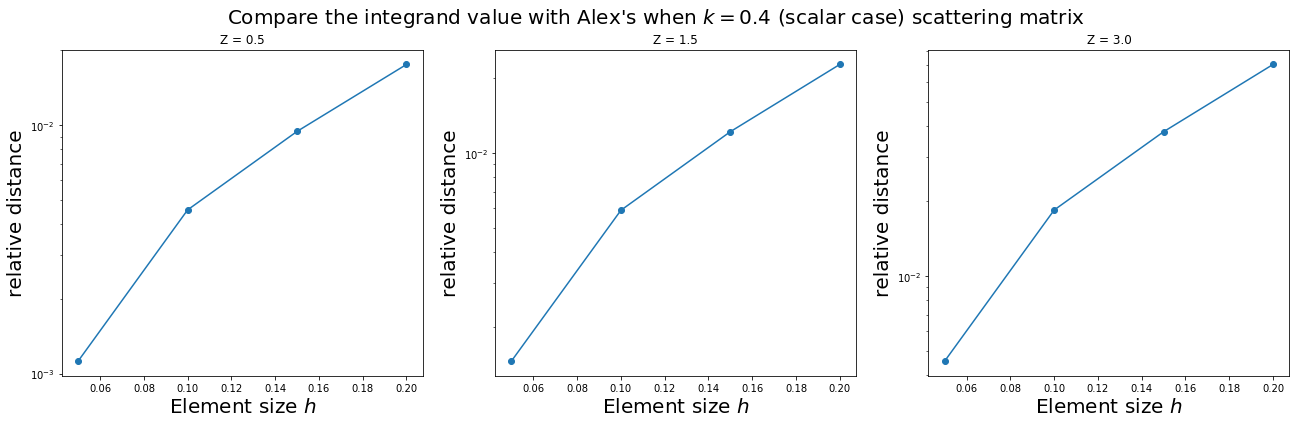

In [5]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(22, 6))
ax1.semilogy([0.05,0.1,0.15,0.2], rel_dist_05_mat_k04 ,'o-')
ax1.set_xlabel('Element size $h$', fontsize = 20)
ax1.set_ylabel('relative distance', fontsize = 20)
ax1.title.set_text('Z = 0.5')

ax2.semilogy([0.05,0.1,0.15,0.2], rel_dist_15_mat_k04,'o-')
ax2.set_xlabel('Element size $h$', fontsize = 20)
ax2.set_ylabel('relative distance', fontsize = 20)
ax2.title.set_text('Z = 1.5')

ax3.semilogy([0.05,0.1,0.15,0.2], rel_dist_3_mat_k04,'o-')
ax3.set_xlabel('Element size $h$', fontsize = 20)
ax3.set_ylabel('relative distance', fontsize = 20)
ax3.title.set_text('Z = 3.0')

fig.suptitle('Compare the integrand value with Alex\'s when $k = 0.4$ (scalar case) scattering matrix', fontsize = 20)
fig.savefig('mat h-refine integrand 04 scalar.pdf')

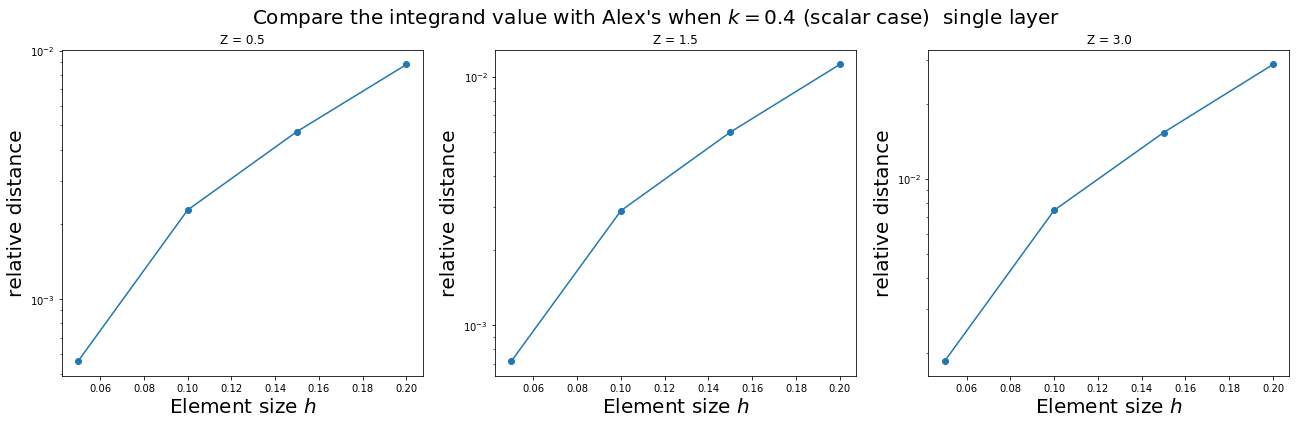

In [6]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(22, 6))
ax1.semilogy([0.05,0.1,0.15,0.2], rel_dist_05_slp_k04 ,'o-')
ax1.set_xlabel('Element size $h$', fontsize = 20)
ax1.set_ylabel('relative distance', fontsize = 20)
ax1.title.set_text('Z = 0.5')

ax2.semilogy([0.05,0.1,0.15,0.2], rel_dist_15_slp_k04,'o-')
ax2.set_xlabel('Element size $h$', fontsize = 20)
ax2.set_ylabel('relative distance', fontsize = 20)
ax2.title.set_text('Z = 1.5')

ax3.semilogy([0.05,0.1,0.15,0.2], rel_dist_3_slp_k04,'o-')
ax3.set_xlabel('Element size $h$', fontsize = 20)
ax3.set_ylabel('relative distance', fontsize = 20)
ax3.title.set_text('Z = 3.0')

fig.suptitle('Compare the integrand value with Alex\'s when $k = 0.4$ (scalar case)  single layer', fontsize = 20)
fig.savefig('slp h-refine integrand 04 scalar.pdf')

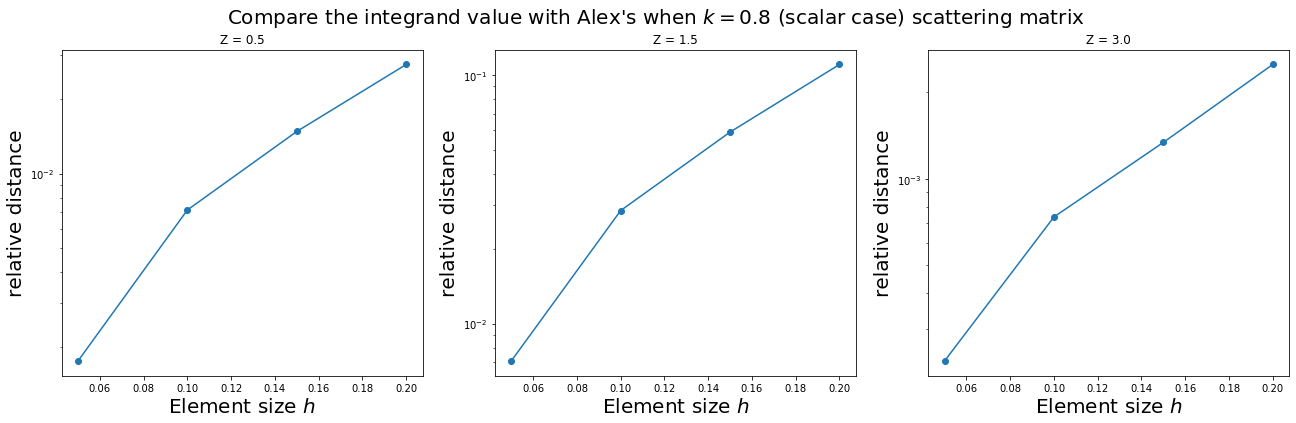

In [7]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(22, 6))
ax1.semilogy([0.05,0.1,0.15,0.2], rel_dist_05_mat_k08 ,'o-')
ax1.set_xlabel('Element size $h$', fontsize = 20)
ax1.set_ylabel('relative distance', fontsize = 20)
ax1.title.set_text('Z = 0.5')

ax2.semilogy([0.05,0.1,0.15,0.2], rel_dist_15_mat_k08,'o-')
ax2.set_xlabel('Element size $h$', fontsize = 20)
ax2.set_ylabel('relative distance', fontsize = 20)
ax2.title.set_text('Z = 1.5')

ax3.semilogy([0.05,0.1,0.15,0.2], rel_dist_3_mat_k08,'o-')
ax3.set_xlabel('Element size $h$', fontsize = 20)
ax3.set_ylabel('relative distance', fontsize = 20)
ax3.title.set_text('Z = 3.0')

fig.suptitle('Compare the integrand value with Alex\'s when $k = 0.8$ (scalar case) scattering matrix', fontsize = 20)
fig.savefig('mat h-refine integrand 08 scalar.pdf')

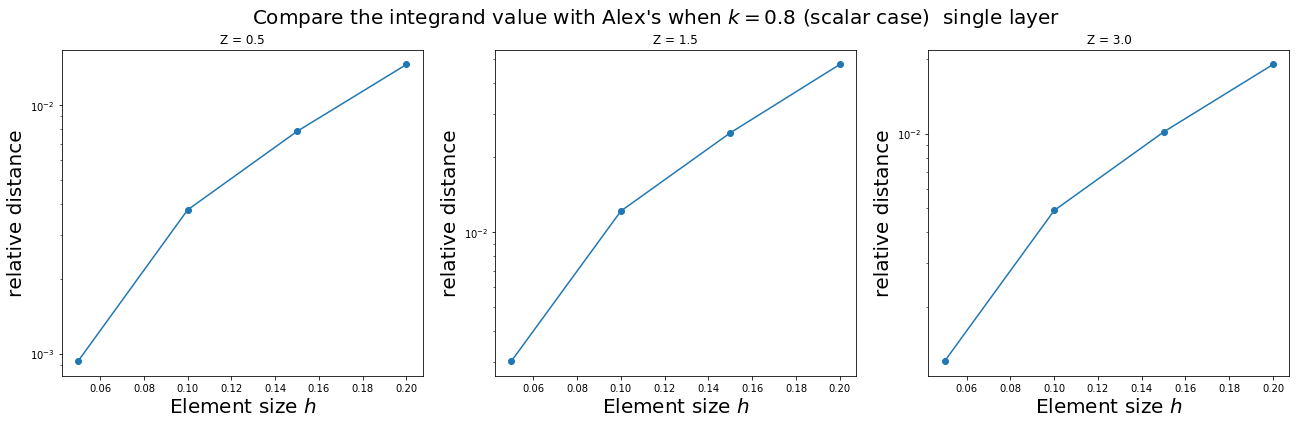

In [8]:
fig, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(22, 6))
ax1.semilogy([0.05,0.1,0.15,0.2], rel_dist_05_slp_k08 ,'o-')
ax1.set_xlabel('Element size $h$', fontsize = 20)
ax1.set_ylabel('relative distance', fontsize = 20)
ax1.title.set_text('Z = 0.5')

ax2.semilogy([0.05,0.1,0.15,0.2], rel_dist_15_slp_k08,'o-')
ax2.set_xlabel('Element size $h$', fontsize = 20)
ax2.set_ylabel('relative distance', fontsize = 20)
ax2.title.set_text('Z = 1.5')

ax3.semilogy([0.05,0.1,0.15,0.2], rel_dist_3_slp_k08,'o-')
ax3.set_xlabel('Element size $h$', fontsize = 20)
ax3.set_ylabel('relative distance', fontsize = 20)
ax3.title.set_text('Z = 3.0')

fig.suptitle('Compare the integrand value with Alex\'s when $k = 0.8$ (scalar case)  single layer', fontsize = 20)
fig.savefig('slp h-refine integrand 08 scalar.pdf')

In [9]:
alpha_02_mat_04 = []
for i in range(len(mat_h_02_04)):
    alpha_02_mat_04.append(abs(mat_h_02_04[i] - Alex_04[i]))
    
alpha_015_mat_04 = []
for i in range(len(mat_h_02_04)):
    alpha_015_mat_04.append(abs(mat_h_015_04[i] - Alex_04[i]))
    
alpha_01_mat_04 = []
for i in range(len(mat_h_02_04)):
    alpha_01_mat_04.append(abs(mat_h_01_04[i] - Alex_04[i]))
    
alpha_005_mat_04 = []
for i in range(len(mat_h_02_04)):
    alpha_005_mat_04.append(abs(mat_h_005_04[i] - Alex_04[i]))

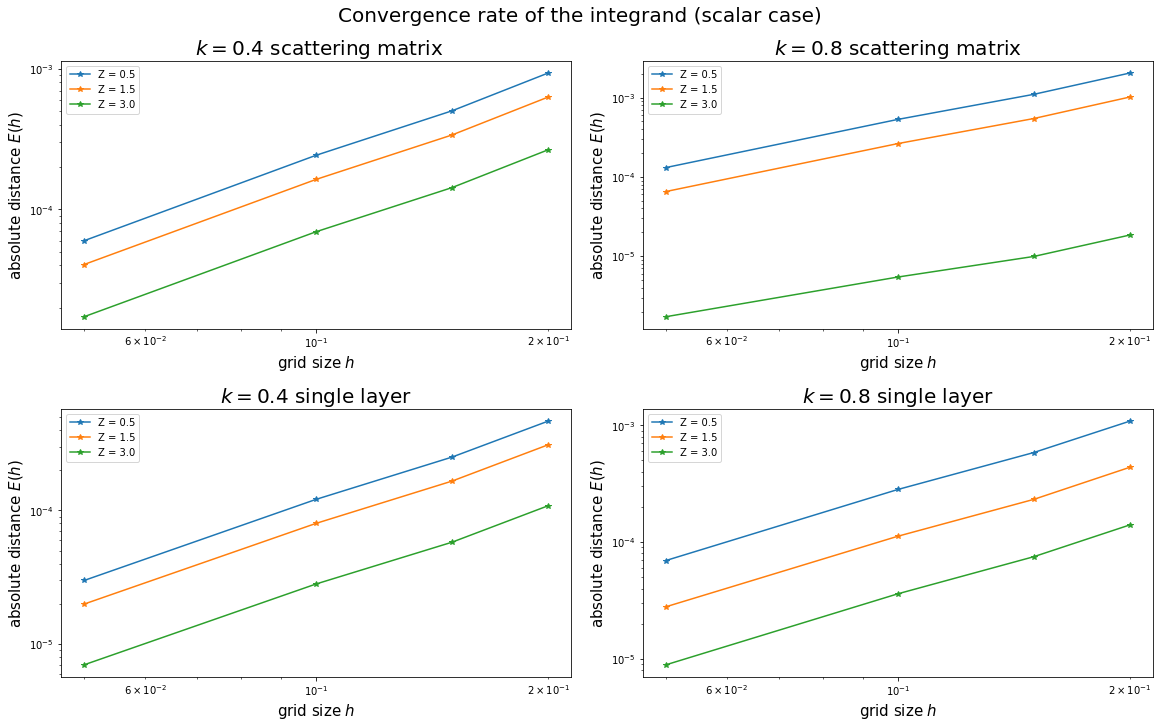

In [14]:
fig, axs =  plt.subplots(2, 2, figsize = [16,10], constrained_layout=True)
x_axis = [0.05, 0.1, 0.15, 0.2]
axs[0,0].loglog(x_axis, [alpha_005_mat_04[0], alpha_01_mat_04[0], alpha_015_mat_04[0], alpha_02_mat_04[0]], '*-')
axs[0,0].loglog(x_axis, [alpha_005_mat_04[1], alpha_01_mat_04[1], alpha_015_mat_04[1], alpha_02_mat_04[1]], '*-')
axs[0,0].loglog(x_axis, [alpha_005_mat_04[2], alpha_01_mat_04[2],alpha_015_mat_04[2],alpha_02_mat_04[2]], '*-')
axs[0,0].legend(['Z = 0.5', 'Z = 1.5', 'Z = 3.0'], fontsize = 10)
axs[0,0].set_xlabel('grid size $h$', fontsize = 15)
axs[0,0].set_ylabel('absolute distance $E(h)$', fontsize = 15)
axs[0,0].set_title(' $k = 0.4$ scattering matrix', fontsize = 20)

axs[0,1].loglog(x_axis, [alpha_005_mat_08[0], alpha_01_mat_08[0], alpha_015_mat_08[0], alpha_02_mat_08[0]], '*-')
axs[0,1].loglog(x_axis, [alpha_005_mat_08[1], alpha_01_mat_08[1], alpha_015_mat_08[1], alpha_02_mat_08[1]], '*-')
axs[0,1].loglog(x_axis, [alpha_005_mat_08[2], alpha_01_mat_08[2],alpha_015_mat_08[2],alpha_02_mat_08[2]], '*-')
axs[0,1].legend(['Z = 0.5', 'Z = 1.5', 'Z = 3.0'], fontsize = 10)
axs[0,1].set_xlabel('grid size $h$', fontsize = 15)
axs[0,1].set_ylabel('absolute distance $E(h)$', fontsize = 15)
axs[0,1].set_title('$k = 0.8$ scattering matrix', fontsize = 20)

axs[1,0].loglog(x_axis, [alpha_005_slp_04[0], alpha_01_slp_04[0], alpha_015_slp_04[0], alpha_02_slp_04[0]], '*-')
axs[1,0].loglog(x_axis, [alpha_005_slp_04[1], alpha_01_slp_04[1], alpha_015_slp_04[1], alpha_02_slp_04[1]], '*-')
axs[1,0].loglog(x_axis, [alpha_005_slp_04[2], alpha_01_slp_04[2],alpha_015_slp_04[2], alpha_02_slp_04[2]], '*-')
axs[1,0].legend(['Z = 0.5', 'Z = 1.5', 'Z = 3.0'], fontsize = 10)
axs[1,0].set_xlabel('grid size $h$', fontsize = 15)
axs[1,0].set_ylabel('absolute distance $E(h)$', fontsize = 15)
axs[1,0].set_title('$k = 0.4$ single layer', fontsize = 20)

axs[1,1].loglog(x_axis, [alpha_005_slp_08[0], alpha_01_slp_08[0], alpha_015_slp_08[0], alpha_02_slp_08[0]], '*-')
axs[1,1].loglog(x_axis, [alpha_005_slp_08[1], alpha_01_slp_08[1], alpha_015_slp_08[1], alpha_02_slp_08[1]], '*-')
axs[1,1].loglog(x_axis, [alpha_005_slp_08[2], alpha_01_slp_08[2], alpha_015_slp_08[2], alpha_02_slp_08[2]], '*-')
axs[1,1].legend(['Z = 0.5', 'Z = 1.5', 'Z = 3.0'], fontsize = 10)
axs[1,1].set_xlabel('grid size $h$', fontsize = 15)
axs[1,1].set_ylabel('absolute distance $E(h)$', fontsize = 15)
axs[1,1].set_title('$k = 0.8$ single layer', fontsize = 20)

fig.suptitle('Convergence rate of the integrand (scalar case)', fontsize = 20)
fig.savefig('convergence rate with Alex in four cases scalar.pdf')

In [41]:
print(np.log(alpha_02_mat_04[0]/alpha_015_mat_04[0])/np.log(0.2/0.15),np.log(alpha_015_mat_04[0]/alpha_01_mat_04[0])/np.log(0.15/0.1), 
     np.log(alpha_01_mat_04[0]/alpha_005_mat_04[0])/np.log(0.1/0.05))

print(np.log(alpha_02_mat_04[1]/alpha_015_mat_04[1])/np.log(0.2/0.15),np.log(alpha_015_mat_04[1]/alpha_01_mat_04[1])/np.log(0.15/0.1), 
     np.log(alpha_01_mat_04[1]/alpha_005_mat_04[1])/np.log(0.1/0.05))

print(np.log(alpha_02_mat_04[2]/alpha_015_mat_04[2])/np.log(0.2/0.15),np.log(alpha_015_mat_04[2]/alpha_01_mat_04[2])/np.log(0.15/0.1), 
     np.log(alpha_01_mat_04[2]/alpha_005_mat_04[2])/np.log(0.1/0.05))

2.1558120699717045 1.793004149000001 2.0197673577636084
2.1620922065440107 1.7926696770252426 2.0115309777897625
2.1566314382215257 1.7803728432446366 2.0087702096277256


In [11]:
alpha_02_mat_08 = []
for i in range(len(mat_h_02_08)):
    alpha_02_mat_08.append(abs(mat_h_02_08[i] - Alex_08[i]))
    
alpha_015_mat_08 = []
for i in range(len(mat_h_02_08)):
    alpha_015_mat_08.append(abs(mat_h_015_08[i] - Alex_08[i]))
    
alpha_01_mat_08 = []
for i in range(len(mat_h_02_08)):
    alpha_01_mat_08.append(abs(mat_h_01_08[i] - Alex_08[i]))
    
alpha_005_mat_08 = []
for i in range(len(mat_h_02_08)):
    alpha_005_mat_08.append(abs(mat_h_005_08[i] - Alex_08[i]))

In [42]:
print(np.log(alpha_02_mat_08[0]/alpha_015_mat_08[0])/np.log(0.2/0.15),np.log(alpha_015_mat_08[0]/alpha_01_mat_08[0])/np.log(0.15/0.1),
     np.log(alpha_01_mat_08[0]/alpha_005_mat_08[0])/np.log(0.1/0.05))

print(np.log(alpha_02_mat_08[1]/alpha_015_mat_08[1])/np.log(0.2/0.15),np.log(alpha_015_mat_08[1]/alpha_01_mat_08[1])/np.log(0.15/0.1),
     np.log(alpha_01_mat_08[1]/alpha_005_mat_08[1])/np.log(0.1/0.05))

print(np.log(alpha_02_mat_08[2]/alpha_015_mat_08[2])/np.log(0.2/0.15),np.log(alpha_015_mat_08[2]/alpha_01_mat_08[2])/np.log(0.15/0.1), 
     np.log(alpha_01_mat_08[2]/alpha_005_mat_08[2])/np.log(0.1/0.05))

2.1576941757158217 1.7945843325822517 2.0191305422686567
2.176804191246432 1.793380460072279 2.010451567339266
2.1695975135105643 1.4721837626191576 1.663847664961956


In [12]:
alpha_02_slp_04 = []
for i in range(len(slp_h_02_04)):
    alpha_02_slp_04.append(abs(slp_h_02_04[i] - Alex_04[i]))
    
alpha_015_slp_04 = []
for i in range(len(slp_h_02_04)):
    alpha_015_slp_04.append(abs(slp_h_015_04[i] - Alex_04[i]))
    
alpha_01_slp_04 = []
for i in range(len(slp_h_02_04)):
    alpha_01_slp_04.append(abs(slp_h_01_04[i] - Alex_04[i]))
    
alpha_005_slp_04 = []
for i in range(len(slp_h_02_04)):
    alpha_005_slp_04.append(abs(slp_h_005_04[i] - Alex_04[i]))

In [45]:
print(np.log(alpha_02_slp_04[0]/alpha_015_slp_04[0])/np.log(0.2/0.15),np.log(alpha_015_slp_04[0]/alpha_01_slp_04[0])/np.log(0.15/0.1), 
     np.log(alpha_01_slp_04[0]/alpha_005_slp_04[0])/np.log(0.1/0.05))

print(np.log(alpha_02_slp_04[1]/alpha_015_slp_04[1])/np.log(0.2/0.15),np.log(alpha_015_slp_04[1]/alpha_01_slp_04[1])/np.log(0.15/0.1), 
     np.log(alpha_01_slp_04[1]/alpha_005_slp_04[1])/np.log(0.1/0.05))

print(np.log(alpha_02_slp_04[2]/alpha_015_slp_04[2])/np.log(0.2/0.15),np.log(alpha_015_slp_04[2]/alpha_01_slp_04[2])/np.log(0.15/0.1), 
     np.log(alpha_01_slp_04[2]/alpha_005_slp_04[2])/np.log(0.1/0.05))

2.16043532110877 1.7954957182218274 2.0191723092745635
2.1810278751651135 1.7957385939306423 2.0090338118650704
2.190447553852091 1.7743381388724437 2.0123483924277057


In [13]:
alpha_02_slp_08 = []
for i in range(len(slp_h_02_08)):
    alpha_02_slp_08.append(abs(slp_h_02_08[i] - Alex_08[i]))
    
alpha_015_slp_08 = []
for i in range(len(slp_h_02_08)):
    alpha_015_slp_08.append(abs(slp_h_015_08[i] - Alex_08[i]))
    
alpha_01_slp_08 = []
for i in range(len(slp_h_02_08)):
    alpha_01_slp_08.append(abs(slp_h_01_08[i] - Alex_08[i]))
    
alpha_005_slp_08 = []
for i in range(len(slp_h_02_08)):
    alpha_005_slp_08.append(abs(slp_h_005_08[i] - Alex_08[i]))

In [46]:
print(np.log(alpha_02_slp_08[0]/alpha_015_slp_08[0])/np.log(0.2/0.15),np.log(alpha_015_slp_08[0]/alpha_01_slp_08[0])/np.log(0.15/0.1), 
     np.log(alpha_01_slp_08[0]/alpha_005_slp_08[0])/np.log(0.1/0.05))

print(np.log(alpha_02_slp_08[1]/alpha_015_slp_08[1])/np.log(0.2/0.15),np.log(alpha_015_slp_08[1]/alpha_01_slp_08[1])/np.log(0.15/0.1), 
     np.log(alpha_01_slp_08[1]/alpha_005_slp_08[1])/np.log(0.1/0.05))

print(np.log(alpha_02_slp_08[2]/alpha_015_slp_08[2])/np.log(0.2/0.15),np.log(alpha_015_slp_08[2]/alpha_01_slp_08[2])/np.log(0.15/0.1), 
     np.log(alpha_01_slp_08[2]/alpha_005_slp_08[2])/np.log(0.1/0.05))

2.1551573066097043 1.7932538490904222 2.0200699176008987
2.2035827397801095 1.7885468644487312 2.0060458085822437
2.1827632636936434 1.8002646214925422 2.018880031918168


In [72]:
lst = np.array([0.0008636231059937407, 0.021742927102106027, 0.03888826941383135, 0.05137446952093932, 0.06035775427606453, 
                0.0671947016470605, 0.0725200631831294, 0.07641558403794195, 0.07884671354081645, 0.07986729359617403, 
                0.07818448491652007, 0.07572509290192692, 0.07231645185992425, 0.06803767517038103, 0.06296295729547029, 
                0.05717131158269913, 0.05075773134050432, 0.043849927854690635])

In [74]:
np.trapz(lst, np.linspace(0.005, 25, 200)[0:18])/2

0.06498199201095844

In [75]:
lll = [0.0008652812417941061, 0.021785393777762337, 0.03896839553729452, 0.05149047385745647, 0.06051093645686163, 
       0.0673876630038951, 0.07275496411158591, 0.07669406211486256, 0.0791705669314415, 0.08023878251533564, 
       0.0800241238019649, 0.07865858999682396, 0.07625365873839278, 0.07290158905721722, 0.06868353505184797,
       0.06367878521640312, 0.057972253800696885, 0.05165537680446068, 0.044821051541401424, 0.037558903797902984,
       0.029954875965623632, 0.02209354285698203, 0.014060025749855137, 0.0059405195524159, -0.002178001484575197,
       -0.010208453149557426, -0.018064440866443265, -0.025660671362430474, -0.03291279689259969, -0.03973699334718963,
       -0.04604989750832222, -0.05176904518878055, -0.056813586537884785, -0.06110509620168467, -0.06456849078643344,
       -0.06713312199319471, -0.06873411201896414, -0.06931405162160018, -0.0688252465514374, -0.06723255836608343, 
       -0.06451678476559716, -0.06067837811770005, -0.05574124804941225, -0.04975629206232964, -0.04280418316917542, 
       -0.03499687043157191, -0.026477246851594135, -0.017416481943923427, -0.00800881450701043, 0.0015361840265079058,
       0.011003125437369919, 0.020181057660361056, 0.02887314266702578, 0.03690465802474583, 0.04412861263089619,
       0.050428780963056696, 0.05572035412874006, 0.059948643411364834, 0.06308640774783134, 0.0651303325261466, 
       0.06609720131245536, 0.06602016448738272, 0.06494538829129232, 0.0629291964496221, 0.0600357355820546,
       0.0563350693287595, 0.051901684373924895, 0.046813261630997895, 0.04114981692210398, 0.03499300956070585,
       0.028425672628194985, 0.02153146969879522, 0.014394634725363368, 0.007099763499174832, -0.0002683659003997882,
       -0.0076249283037549236, -0.014885196546415905, -0.021964633770470556, -0.028779044076916022, -0.03524473392814784,
       -0.04127873864526893, -0.046799126794150644, -0.051725408572447805, -0.05597916305981204, -0.059484377863417204,
       -0.06216921938333699, -0.06396654040194356, -0.06481595221765783, -0.06466583542855575, -0.06347595468285291, 
       -0.0612204694262547, -0.05789138118637778, -0.053502180474325964, -0.048091416608672964, -0.04172575537177526,
       -0.03450195693881842, -0.026547245416679605, -0.018017459347079667, -0.009092759326365853, 2.9073632810779564e-05, 
       0.00914126158877057, 0.018037663378269758, 0.026522330836422255, 0.03441790757496383, 0.04157198301901996, 
       0.04786105797411299, 0.053192032584288416, 0.05750161309893333, 0.060754149087610586, 0.06293849383654217, 
       0.06406446259822314, 0.06415916449194498, 0.06326373675878366, 0.06143038435238897, 0.0587198910508358, 
       0.05519961926452481, 0.05094193444959512, 0.04602293904474207, 0.040521528132715104, 0.03451866737117306, 
       0.02809685684861141, 0.02133967776996943, 0.014331538229789895, 0.007157372209768832, -9.762581594769442e-05, 
       -0.007348038247267038, -0.014508545853358576, -0.021494025517399016, -0.028219753529980497, -0.034601573612186375, 
       -0.040556307004306076, -0.046001853402986105, -0.050857801101150804, -0.055045933260078866, -0.05849099248990488,
       -0.0611216871372868, -0.06287195677624688, -0.06368273840254611, -0.06350370675445118, -0.06229663820884999, 
       -0.06003728047062642, -0.056719450237814675, -0.05235826567711464, -0.04699361884612533, -0.04069299389299022, 
       -0.033553307304492824, -0.02570134612791079, -0.017290128284222318, -0.008498709579609028, 0.0004791155023652744,
       0.009440409887048381, 0.01818308819123127, 0.02651516011587265, 0.03426279055474132, 0.041276440383965565, 
       0.04743587575431665, 0.05264631020233668, 0.05684828878429555, 0.06000552725344135, 0.062106881619514505, 
       0.06316196405190654, 0.06319110070390138, 0.06225496253979835, 0.06038615312977585, 0.0576494610051837,
       0.054117419053125934, 0.049858868694867234, 0.044950809498093554, 0.03947238291343993, 0.033504621578384214, 
       0.027130059481716793, 0.020432340946809745, 0.013497533880112614, 0.006399874355253318, -0.0007613637196040963, 
       -0.007908866868673583, -0.014957345766187869, -0.021822376473630885, -0.028420047307511742, -0.03466718419594455, 
       -0.040480541336315776, -0.0462365848008391, -0.05049539695931579, -0.05453502844528461, -0.05783381137179214, 
       -0.06032267790422524, -0.061938648743009084, -0.06262605177541718, -0.06233670084656441, -0.06103764656844344, 
       -0.058721964901367656, -0.05535889577694932, -0.05098470736065254, -0.04563805988147347, -0.039387055514737805, 
       -0.032327967410563256, -0.02458555491630593, -0.016311177232882015, -0.007657435063729932, 0.0011328584627915469]

In [77]:
np.trapz(lll, np.linspace(0.005, 25, 200))/2

0.011712180396111936

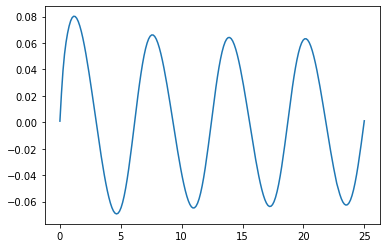

In [78]:
plt.plot(np.linspace(0.005, 25, 200), lll)

In [82]:
1/(np.linspace(0.005,25,200)[23] - np.linspace(0.005,25,200)[73])

-0.15923184636927382